## A simple phylogenetic tree-building algorithm

Written for Assignment 2, Question 3a (phylogenetics) for Semester 2, 2024 in Algorithms for Bioinformatics (COMP90014) at the University of Melbourne.

**Prompt:** a outbreak of Ebola has been detected. Different strains of Ebola have been sequenced, along with sequencing data from the latest case. *Build a tree to identify clusters within the outbreak and which cluster the latest case belongs to*, hence allowing targeted vaccine delivery. 

**Inputs:** a FASTA file of aligned amino acid sequences which are assumed to have been processed through multiple sequence alignment. <br>
**Output:** a phylogenetic tree revealing disease clusters. 

**Workflow:** 
1. A simple phylogenetic tree is build using the neighbour-joining algorithm (agglomerative clustering). 
2. The simple tree is then repeatedly scored and branch and bounding algorithms applied to increase global optima.

**Setting up the environment:**

Before setting up the environment, ensure Tkinter has been installed. This can be installed from the command line using:

    sudo apt-get install -y python3-tk

Tkinter is Python's standard library for creating lightweight and simple Graphical User Interfaces (GUIs). It has been chosen as a simple way of visualising the code's outputs. 

Now to setup and activate a custom Python3 virtual environment with required dependencies for this notebook...

In [1]:
from workflow_utils import setup_custom_venv

setup_custom_venv(requirements_file="requirements/phylotree_ipynb.txt", custom_venv_name="phylotree_venv")


Creating Python virtual environment...
Activating the virtual environment...
Installing required Python modules from requirements/phylotree_ipynb.txt...
Adding virtual environment to Jupyter kernels...
Installed kernelspec phylotree_venv in /home/george/.local/share/jupyter/kernels/phylotree_venv
Setup complete. To run the visualisation, use:
> source phylotree_venv/bin/activate
> python simple_NJ_tree.py


Select the *phylotree_venv* virtual environment as the notebook's kernel. 

And import dependencies into the notebook.

In [2]:
import Bio
import Bio.Align
import networkx as nx
import numpy as np

from collections import defaultdict
from workflow_utils import draw_evo_tree  # import utility function that does basic graph plotting


**Loading sample data:**

The following sample files are used to demonstrate a simple phylotree build:
- https://github.com/melbournebioinformatics/COMP90014_2024/raw/master/assignments/data/ebola_glycoproteins.fasta
- https://github.com/melbournebioinformatics/COMP90014_2024/raw/master/assignments/data/ebola_glycoproteins_MSA.fasta

Download these and place in a subfolder called /data if they haven't been already. <br>
Alternatively use the following wget to wget the data. :)

In [3]:
%%bash

# create a /data directory if it doesn't exist
mkdir -p data

# download the files into /data
wget -O data/ebola_glycoproteins.fasta https://github.com/melbournebioinformatics/COMP90014_2024/raw/master/assignments/data/ebola_glycoproteins.fasta
wget -O data/ebola_glycoproteins_MSA.fasta https://github.com/melbournebioinformatics/COMP90014_2024/raw/master/assignments/data/ebola_glycoproteins_MSA.fasta


--2024-11-18 01:32:23--  https://github.com/melbournebioinformatics/COMP90014_2024/raw/master/assignments/data/ebola_glycoproteins.fasta
Resolving github.com (github.com)... 4.237.22.38
Connecting to github.com (github.com)|4.237.22.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/melbournebioinformatics/COMP90014_2024/master/assignments/data/ebola_glycoproteins.fasta [following]
--2024-11-18 01:32:23--  https://raw.githubusercontent.com/melbournebioinformatics/COMP90014_2024/master/assignments/data/ebola_glycoproteins.fasta
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50633 (49K) [text/plain]
Saving to: ‘data/ebola_glycoproteins.fasta’

     0K .......... .......... .......... .......... 

The raw amino acid sequences from the .fasta file can now be loaded in:

In [4]:
def load_sequences(filepath: str):  # sequence loading function
    from Bio import SeqIO
    seqs = []
    for seq in SeqIO.parse(filepath, "fasta"):
        seqs.append((seq.name, str(seq.seq)))
    return seqs

# load Ebola sequences into a list
EBOLA_SEQS_FILEPATH = "data/ebola_glycoproteins.fasta"
seqs = load_sequences(EBOLA_SEQS_FILEPATH)


An snippet of the dataset:

In [5]:
print("Number of proteins:", len(seqs))
print("Number of attributes per entry in the dataset:", len(seqs[0]))
print("Number of diverse of amino acid lengths:", len(set(len(seq) for _, seq in seqs)))
print()
print("Average length of diverse of amino acid lengths:", np.mean(list(len(seq) for _, seq in seqs)))
print()
print(f"Snippet of dataset in the form:\n{31*'-'}")
print("protein name:\t\tsequence")
print()
for name, seq in seqs[:5]:
    print(name + ":\t" + seq[:20])  # name and first 20 amino acids per protein


Number of proteins: 68
Number of attributes per entry in the dataset: 2
Number of diverse of amino acid lengths: 1

Average length of diverse of amino acid lengths: 676.0

Snippet of dataset in the form:
-------------------------------
protein name:		sequence

STRAIN_W_62262.1:	MGVTGILQLPRDRFKRTSFF
STRAIN_W_62239.1:	MGVTGILQLPRDRFKRTSFF
STRAIN_W_62230.1:	MGVTGILQLPRDRFKRTSFF
STRAIN_W_62221.1:	MGVTGILQLPRDRFKRTSFF
STRAIN_W_62212.1:	MGVTGILQLPRDRFKRTSFF


**Agglomerative clustering phylogenetic tree-building plan:**

Set up the tree leaves and distance matrix: <br>
1. Preprocess sequences and reduce dataset.
2. Construct sequence alignment distance matrix.
3. Initialise graph with leaf nodes.

Iteratively perform agglomerative clustering to build a tree: <br>
1. Find the node pair which are closest to each other and have the greatest average distance from other nodes.
2. Connect this closest node pair to their parent node on the graph.
3. Update the distance matrix accordingly. 


**Setting up graph and distance matrix data structures:**

Reduce dataset to unique and relevant sequences.

In [6]:
def preprocessing(seqs):  
    """
    Sorts a list of sequences into lexicographic order by their amino acid sequence. 
    Sorted sequences are more easily referenceable across a sorted distance matrix using their sort index.
    This is useful for simplification in cases where multiple samples share the same sequence.
    
    Input: a list of amino acid sequence tuples in format (name, sequence)

    Output: a dictionary of sorted amino acid sequences {sequence: [a list of sample names]}
    """

    all_dict = {name:seq for name,seq in seqs}  # unpack and sort seqs
    all_dict = dict(sorted(all_dict.items()))
    
    seqs_dict = defaultdict(list)  # seqs_dict = {seq:[list of strain names]}
    for name,seq in all_dict.items():
        seqs_dict[seq].append(name)

    return seqs_dict # all sublisted names are sorted

Set up a pairwise distance matrix by comparing sequences using an external substitution matrix.

During runtime: a sequence dictionary is setup alongside the distance matrix to track which sequences
are in which column/row. 
- The sequences are referenceable through their dictionary matrix, which can be converted through to a node_id, which is its ultimate identity in a special node dictionary that reflects each individual node in the phylogenetic tree's graph. 
- The special node dictionary is a structure that accounts for individual nodes due to the preprocessing step which condensed all samples down to unique sequences.

In [7]:
def get_distance_matrix(seq_dict):
    """
    Creates a pairwise distance matrix between unique sequences in the sequence dictionary.
    The pairwise alignment uses PAM30 global alignment of regions with expected close protein similarity. 

    Input: a dictionary of sorted amino acid sequences {sequence: [a list of sample names]}.
        The input dictionary represents the sequences found on the leaf nodes of the tree.
    OUtput: a Numpy matrix (nested list) of the pairwise distances between parentless/free nodes in the current graph.
    """
    aligner = Bio.Align.PairwiseAligner()  # use aligner to make a distance matrix for protein sequences
    aligner.mode = 'global'  # global protein sequence alignment of the same region
    pam30 = Bio.Align.substitution_matrices.load('PAM30')  # using PAM as this is global alignment
    aligner.substitution_matrix = pam30  # using PAM30 due to expected close similarity

    n = len(seq_dict)
    dist_matrix = np.zeros((n, n))  # init dist matrix

    # unpack sorted sequence from sequence dict
    unpack_all = sorted(seq_dict.keys())
    for i in range(n):  # pairwise sequence comparison of protein seqs using PAM30 
        for j in range(i + 1, n):
            alignment = aligner.align(unpack_all[i], unpack_all[j])
            score = -alignment.score  # use negative alignment similarity score as distance
            dist_matrix[i, j] = dist_matrix[j, i] = score

    # normalise the distance matrix
    if np.max(dist_matrix) != np.min(dist_matrix):
        dist_matrix = (dist_matrix - np.min(dist_matrix)) / (np.max(dist_matrix) - np.min(dist_matrix))
    
    return dist_matrix  # returns sorted distance matrix, in same order as entries in seq_dict



Initialise the tree using a NetworkX graph.

In [8]:
def set_leaf_nodes(graph, seq_dict, node_id):
    """
    Creates an initial NetworkX graph by setting the leaf nodes.
    Nodes are set using their index (node_id) in the sorted node dictionary from preprocessing step 1. 

    Input: the preprocessed sorted dictionary of sequences {sequence: [list of sample names]}
    Output: a NetworkX graph of leaf nodes. Each node holds the sequence of a previous sample or case.
    """
    node_dict = {}

    for seq in seq_dict:  # each unique sequence has a list of related strains in seq_dict's defaultdict(list)
        for strain_name in range(len(seq_dict[seq])):
            
            node_dict.update({node_id:seq_dict[seq][strain_name]})  # track added nodes in a node_dict
            graph.add_node(node_id, label=seq_dict[seq][strain_name])  # add leaves to graph
            node_id += 1  # keep unique node id

    return graph, node_id, node_dict

**Neighbour-joining implementation:**

Calculate Qij, which is the value which quantifies how alike a pair of node sequences are to each other and how unalike or distant the pair is to all the other sequences. 

In [9]:
# find average distance each node is from other nodes
def node_avg_dist(i, num_nodes, dist_matrix):
    return np.mean([dist_matrix[i][j] for j in range(num_nodes) if i != j])

In [10]:
# find closeness proximity and average distance from other nodes for each node pair
def calculate_Qij(i, j, num_nodes, dist_matrix):  # returns the Qij score for the node pair
    return dist_matrix[i][j] - node_avg_dist(i, num_nodes, dist_matrix) - node_avg_dist(j, num_nodes, dist_matrix)


In [11]:
# find starting node pair through smallest Qij
def closest_pair(dist_matrix):
    best_Qij = np.inf
    n = len(dist_matrix)  # go through matrix and get Qij score per node pair

    for i in range(n):  # iterate through pairs and check Qij score
        for j in range(i + 1, n):
            Qij = calculate_Qij(i, j, n, dist_matrix)

            if Qij < best_Qij:  # set best Qij
                best_Qij = Qij
                pair = (i,j)

    return pair  # best pair returned as indexes of dist_matrix

Update the distance matrix by replacing the old node pair with a new internal/parent node and the related pairwise distances.

In [12]:
def remove_pair(pair, matrix_dict, dist_matrix):
    """
    Receives the index positions of the best Qij pair and uses the index values to 
    remove the best Qij pair from the distance matrix and a linked matrix dictionary that
    summarises the identity of the columns/rows in the distance matrix.

    Input: index positions of the best Qij pair to remove, a distance matrix and its linked index dictionary.
    Output: a distance matrix and linked index dictionary with best Qij pair removed.
    """
    pair = sorted(pair, reverse=True)  # remove later row/column first to maintain indexing

    cleaned_dict = {a: b for x, (a, b) in enumerate(matrix_dict.items()) if x not in pair}
    dist_matrix = np.delete(dist_matrix, pair, axis=0)  # remove rows
    dist_matrix = np.delete(dist_matrix, pair, axis=1)  # remove columns

    return dist_matrix, cleaned_dict



In [13]:
def update_distances(i, j, k, dist_matrix, matrix_dict, node_dict, node_id):
    """
    Creates a new entry in the distance matrix and its linked index dictionary.
    The new entry represents the last common ancestor of the best Qij pair.
    This can also be thought of as their parent node.

    Input: the indexes of the new and old nodes in the linked index dictionary, 
        the pairwise distance matrix and its linked index dictionary,
        the overarching node dictionary linked to the main tree graph,
        and the related new parent node_id.
    Output: the updated distance matrix with new parent node and its linked index dictionary,
        and the updated overarching node dictionary linked to the main tree graph.
    """
    new_dist_matrix = np.zeros((k + 1, k + 1))  # init new matrix
    new_dist_matrix[:k, :k] = dist_matrix  # copy old matrix into top left, to preserve sort order
    
    for m in range(k):  # add k distances from other nodes, updates new parent node distances
        new_dist_matrix[k][m] = 0.5 * (dist_matrix[i][m] + dist_matrix[j][m] - dist_matrix[i][j])
        new_dist_matrix[m][k] = new_dist_matrix[k][m]

    matrix_dict.update({k:[node_id]}) # define new parent node in matrix_dict
    node_dict.update({node_id:node_id}) # define new parent node in overall node_dict

    return new_dist_matrix, matrix_dict, node_dict

In [14]:
def add_pair_parent(pair, dist_matrix, matrix_dict, node_dict, node_id, graph):
    """
    Combines a pair removal function and a distance updating function.
    Adds a new parent node to the phylotree graph, 
    while also updating indexes and data in relevant dictionary and matrix data structures.

    Inputs: the best Qij pair, new node_id, distance matrix, matrix dictionary, and overall node dictionary.
    Outputs: the updated distance matrix and its linked index dictionary,
        the updated phylogenetic tree graph and its linked overall node dictionary,
        and the ID number of the most recently added node. 
    """
    i, j = pair  # unpack best i,j indexes 
    k = len(dist_matrix)  # newest row/column index
    dist_matrix, matrix_dict, node_dict = update_distances(i, j, k, dist_matrix, matrix_dict, node_dict, node_id)

    # get new edge lengths from i,j to the new internal node
    new_i_edge = 0.5 * (dist_matrix[i][j] + node_avg_dist(i, k, dist_matrix) - node_avg_dist(j, k, dist_matrix))
    new_j_edge = dist_matrix[i][j] - new_i_edge
    new_edges = (new_i_edge, new_j_edge)

    graph.add_node(node_id, label=node_id)  # add new parent node to graph
    
    # get names of indexed seqs in matrix_dict, and use them to get their node index in node_dict
    for x in range(len(pair)):  # for i and j edges
        for matrix_index, seq in enumerate(matrix_dict):  # index matrix dict columns
            if matrix_index == pair[x]:  # proceed with only index-matched dict entries
                    
                for matrix_name in matrix_dict[seq]:  # get names from matrix_dict {seq:[names]}
                    for node_index in node_dict:  # find matched matrix_dict name in node_dict
                        dict_name = node_dict[node_index]  
                        
                        if dict_name == matrix_name:  # cross-ref dicts with names and get node index
                            graph.add_edge(node_id, node_index, len=new_edges[x])  # add graph edges

    dist_matrix, matrix_dict = remove_pair(pair, matrix_dict, dist_matrix)  # remove from matrix/dict
    node_id += 1  # keep track of node ids added

    return dist_matrix, matrix_dict, node_dict, node_id, graph

The previous steps which were defined can now be combined into the iterative agglomerative clustering process to create the full phylogenetic tree.

**Main neighbour-joining function:**

In [15]:
def build_evo_tree(sequences):  # main function
    """
    Takes a list of protein sequences, reduces them to unique sequences and iteratively builds
    a tree by comparing pairs of sequences using the neighbour-joining method.

    Input: a list of amino acide sequences from a .fasta file.
    Output: A NetworkX graph

    """
    G = nx.DiGraph()  # init variables
    node_id = 0
    matrix_dict = preprocessing(seqs)

    G, node_id, node_dict = set_leaf_nodes(G, matrix_dict, node_id)  # init graph (leaves)
    dist_matrix = get_distance_matrix(matrix_dict)  # all seqs dict: {seq:[list of strain names]}

    while len(dist_matrix) > 2:  # do Neighbour-Joining from leaves
        pair = closest_pair(dist_matrix) 
        dist_matrix, matrix_dict, node_dict, node_id, G = add_pair_parent(pair, dist_matrix, matrix_dict, node_dict, node_id, G)
    pair = closest_pair(dist_matrix)  # add root node
    dist_matrix, matrix_dict, node_dict, node_id, G = add_pair_parent(pair, dist_matrix, matrix_dict, node_dict, node_id, G)

    return G

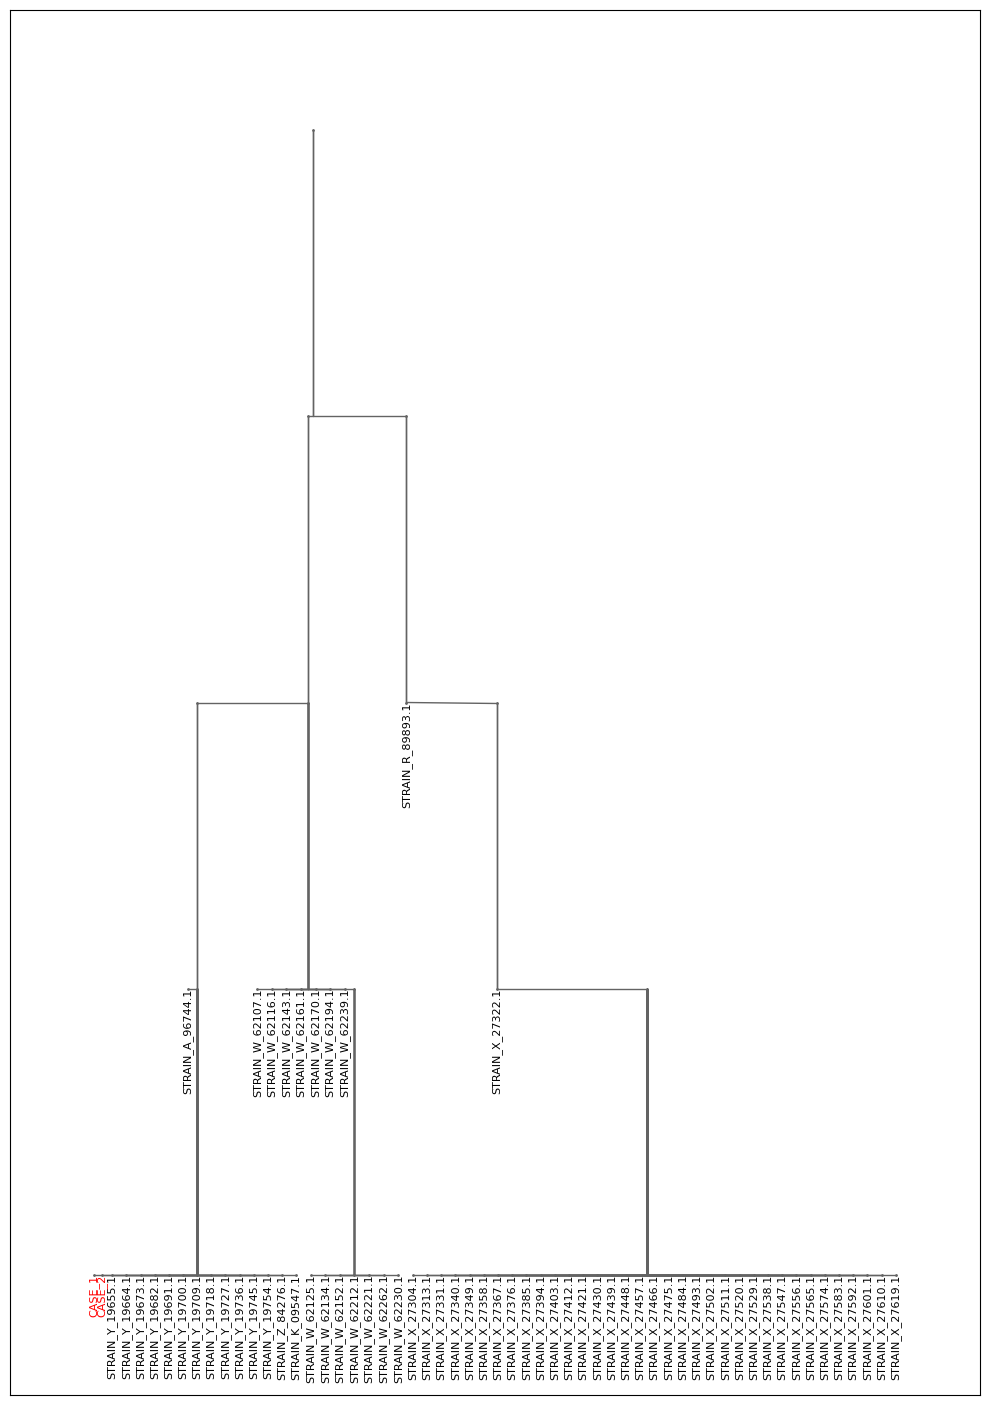

In [16]:
seqs = load_sequences(EBOLA_SEQS_FILEPATH)
G = build_evo_tree(seqs)
draw_evo_tree(G)
